## Clustering structures into chromosome Xi and Xa

In [1]:
import os
original_path = os.getcwd()
root = '/rhome/yhu/bigdata/proj/experiment_GIST'
os.chdir(root)
new_path = os.getcwd()
print('redirect path: \n\t{} \n-->\t{}'.format(original_path, new_path))
print('root: {}'.format(root))

from GIST.prepare.utils import load_hic, load_hic, iced_normalization
from GIST.visualize import display, load_data
from GIST.validation.utils import load_df_fish3d, fish3d_format, load_tad_bed
from GIST.validation.utils import pdist_3d, load_tad_bed, select_loci, remove_failed
from GIST.validation.validation_tad import select_structure3d
from GIST.validation.ab import normalizebydistance, decomposition, correlation, plot
from GIST.validation.ab import fit_genomic_spatial_func

import torch
import numpy as np
from numpy import linalg as LA
from numpy.ma import masked_array
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
import tensorly as tl
from tensorly.decomposition import parafac2
from sklearn import preprocessing

from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.spatial.transform import Rotation as R
from scipy.optimize import curve_fit
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import leaves_list
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

redirect path: 
	/bigdata/wmalab/yhu/proj/notes/exp_GIST 
-->	/bigdata/wmalab/yhu/proj/experiment_GIST
root: /rhome/yhu/bigdata/proj/experiment_GIST


/rhome/yhu/bigdata/.conda/envs/env_viz/lib/python3.8/site-packages/iced/normalization/_ca_utils.py:8: UserWarning: The API of this module is likely to change. Use only for testing purposes
  warnings.warn(
Using backend: pytorch


In [2]:
chrom = 'X'
SAVE_FIG = True
font = {'size': 18}
matplotlib.rc('font', **font)

# setup saved_path
# load config .json

configuration_path = os.path.join(root, 'data')
configuration_name = 'config_predict_{}.json'.format(chrom)
info, config_data = load_data.load_configuration(configuration_path, configuration_name)
resolution = info['resolution']
# info['hyper'] =  '10kb_predict_{}'.format(chrom)
# info['ncluster'] = 7
print(info['hyper'])

validation_name = 'XaXi'
saved_path = os.path.join(root, 'figures', validation_name, info['cell'], 'chr{}'.format(chrom))
os.makedirs(saved_path, exist_ok=True)
print('figure saved in {}'.format(saved_path))

10kb_predict_v2_X
figure saved in /rhome/yhu/bigdata/proj/experiment_GIST/figures/XaXi/Rao2014-IMR90-MboI-allreps-filtered/chrX


## Load FISH TAD data

In [3]:
def get_fish3d(path, name): 
    fish_df = load_df_fish3d(path, name)
    fish3d = fish3d_format(fish_df)
    
    res = []
    for i in np.arange(fish3d.shape[0]):
        tmp = fish3d[i,:,:].squeeze()
        tmpind = np.isnan(tmp[:,0])
        if np.any(tmpind):
            continue
        res.append(tmp)

    x0 = res[0].squeeze()
    x0 = x0 - x0.mean(axis=0)
    resR = []
    for i, x in enumerate(res):
        x = x - x.mean(axis=0)
        eR, _ = R.align_vectors(x0, x)
        x = eR.apply(x)
        resR.append(x)
         
    fish3d = np.stack(resR, axis=0)
    nm_fish3d = np.nanmean(fish3d, axis=0)

    print('fish3d shape: ', fish3d.shape)
    print('ignoring NaNs mean fish3d shape: ', nm_fish3d.shape)
    return nm_fish3d, fish3d

In [4]:
path = os.path.join(root, 'data', 'FISH', 'geometry_coo')
name = 'FISH_Chr{}i.xyz'.format(chrom)
nm_fishXi3d, fishXi3d = get_fish3d(path, name)

path = os.path.join(root, 'data', 'FISH', 'geometry_coo')
name = 'FISH_Chr{}a.xyz'.format(chrom)
nm_fishXa3d, fishXa3d = get_fish3d(path, name)

loading fish3d excel file FISH_ChrXi.xyz
fish3d shape:  (48, 40, 3)
ignoring NaNs mean fish3d shape:  (40, 3)
loading fish3d excel file FISH_ChrXa.xyz
fish3d shape:  (41, 40, 3)
ignoring NaNs mean fish3d shape:  (40, 3)


In [5]:
fishXi_pdist = pdist_3d(fishXi3d)
print('mean Xi pdist shape: ', np.nanmean(fishXi_pdist, axis=0).shape)
print('Xi pdist shape: ', fishXi_pdist.shape)

fishXa_pdist = pdist_3d(fishXa3d)
print('mean Xa pdist shape: ', np.nanmean(fishXa_pdist, axis=0).shape)
print('Xa pdist shape: ', fishXa_pdist.shape)

mean Xi pdist shape:  (40, 40)
Xi pdist shape:  (48, 40, 40)
mean Xa pdist shape:  (40, 40)
Xa pdist shape:  (41, 40, 40)


## Density of distance matrices between Xa and Xi

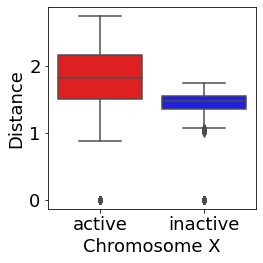

In [6]:
nm_fishXi_pdist = np.nanmean(fishXi_pdist, axis=0)
nm_fishXa_pdist = np.nanmean(fishXa_pdist, axis=0)
mask = np.mask_indices(nm_fishXi_pdist.shape[0], np.triu, 0)
filter_Xi = nm_fishXi_pdist[mask]
filter_Xa = nm_fishXa_pdist[mask]
dist = np.concatenate((filter_Xa, filter_Xi))
cluster = np.append(['active']*len(filter_Xa), ['inactive']*len(filter_Xi) )
d = {'Distance': dist, 'Chromosome X': cluster}
df = pd.DataFrame(data=d)
pal = {'active':'Red', 'inactive':'Blue'}

fig, axs = plt.subplots(1,1, figsize=(4, 4))
sns.boxplot(x="Chromosome X", y="Distance", palette=pal, data=df, ax=axs)
fig.tight_layout()
fig.show()

In [7]:
# save the figure
if SAVE_FIG:
    sp = os.path.join(saved_path, 'AI_True_distance_boxplot_{}.pdf'.format(chrom))
    fig.savefig(sp, format='pdf')
    sp = os.path.join(saved_path, 'AI_True_distance_boxplot_{}.png'.format(chrom))
    fig.savefig(sp, format='png')

In [8]:
res = ttest_ind(filter_Xa, filter_Xi, alternative="greater")
print(res)

Ttest_indResult(statistic=16.645775956321287, pvalue=6.66152660574275e-58)


## Load Prediction of 3D structures

In [9]:
# # load config .json
# configuration_path = os.path.join(root, 'data')
# configuration_name = 'config_predict_{}.json'.format(chrom)
# info, config_data = load_data.load_configuration(configuration_path, configuration_name)
# resolution = info['resolution']

# load dataset
dataset_path = os.path.join(root, 'data', info['cell'], info['hyper'])
dataset_name = 'dataset.pt'
HD = load_data.load_dataset(dataset_path, dataset_name)
graph, feat, ratio, indx  = HD[0]
raw_id = graph['top_graph'].ndata['id'].cpu().numpy()
rmNaN_id = np.arange(len(raw_id))
raw2rm = {} # raw -> rm id
rm2raw = {} # rm -> raw id
for A, B in zip(raw_id, rmNaN_id):
    raw2rm[A] = B
    rm2raw[B] = A
    
# load prediction
prediction_path = os.path.join(root, 'data', info['cell'], info['hyper'], 'output')
prediction_name = 'prediction.pkl'
prediction = load_data.load_prediction(prediction_path, prediction_name)
print('load data path: {}, {}'.format(prediction_path, prediction_name) )

# assignment
structures = dict()
structures['GIST'] = prediction['{}_0'.format(chrom)]['structures']
xweights = prediction['{}_0'.format(chrom)]['structures_weights']
if xweights is not None:
    xweights = xweights.astype(float).flatten()
    print('proportion: {}'.format(100*xweights))
true_cluster = np.array(prediction['{}_0'.format(chrom)]['true_cluster'])
predict_cluster = np.array(prediction['{}_0'.format(chrom)]['predict_cluster'][0])
print( 'GIST structure shape: ', structures['GIST'].shape )

load data path: /rhome/yhu/bigdata/proj/experiment_GIST/data/Rao2014-IMR90-MboI-allreps-filtered/10kb_predict_v2_X/output, prediction.pkl
proportion: [2.51648072 2.66094021 2.21911836 2.91675143 2.61596423 2.116042
 2.53762286 2.69882269 2.25314293 2.45146081 2.60362644 2.2504542
 2.50098072 2.32363027 2.45287623 2.32519601 2.89032012 2.49353461
 2.32190061 2.46263575 2.14467458 2.21742596 2.55653951 2.55741123
 2.75887102 2.30937023 2.63164956 2.63491143 2.73391642 2.5556853
 2.67431792 2.73732431 2.74963249 2.42803618 2.11946927 2.37604696
 2.59369221 2.56841686 2.49576699 2.5453452 ]
GIST structure shape:  (13694, 40, 3)


In [10]:
path = os.path.join(root, 'data', 'FISH', 'loci_position')
name = 'hg19_Chr{}.bed'.format(chrom)
df = load_tad_bed(path, name)
select_idx = select_loci(df, resolution)
for i, idx in enumerate(select_idx):
    arr = np.intersect1d(raw_id, idx)
    select_idx[i] = np.array([ raw2rm[x] for x in arr ] )

In [11]:
data3d = structures['GIST']
index = select_idx
N = data3d.shape[0]
K = data3d.shape[1]
M = len(index)
res = np.empty((M, K, 3))
for i, idx in enumerate(index):
    res[i, :, :] = np.nanmean( data3d[idx.astype(int), :, :], axis=0, keepdims=True)
print('res shape: ', res.shape)
xTAD_3d = res.transpose( (1, 0, 2) )
print('after transpose shape: ', xTAD_3d.shape)
xTAD_pdist = pdist_3d(xTAD_3d)
print('pdist shape: ', np.nanmean(xTAD_pdist, axis=0).shape)

res shape:  (40, 40, 3)
after transpose shape:  (40, 40, 3)
pdist shape:  (40, 40)


## Clustering

- Decomposition: parafac2
- Cluster: hierarchy linkage, metric: 'euclidean', method: 'average'

In [12]:
best_err = np.inf
decomposition = None
tensor =  xTAD_pdist
true_rank = info['ncluster']+1 
print(true_rank)
for run in range(4):
    print(f'Training model {run}', end=', ')
    trial_decomposition, trial_errs = parafac2(tensor, true_rank, return_errors=True, tol=1e-8, n_iter_max=800, random_state=run)
    print(f'Final error: {trial_errs[-1]}')
    if best_err > trial_errs[-1]:
        best_err = trial_errs[-1]
        err = trial_errs
        decomposition = trial_decomposition
    print('-------------------------------')
print(f'Best model error: {best_err}')

10
Training model 0, Final error: 0.12607475625063447
-------------------------------
Training model 1, Final error: 0.1261756096198319
-------------------------------
Training model 2, Final error: 0.12501027673238027
-------------------------------
Training model 3, Final error: 0.1260830022849217
-------------------------------
Best model error: 0.12501027673238027


In [13]:
est_tensor = tl.parafac2_tensor.parafac2_to_tensor(decomposition)
est_weights, (est_A, est_B, est_C) = tl.parafac2_tensor.apply_parafac2_projections(decomposition)
mest_A = np.mean(est_A, axis=0)
sign = np.sign(mest_A)
print(sign, mest_A)
mest_A = mest_A*sign
ind = np.argsort(mest_A)
est_A = est_A[:,ind]*sign[ind]

[ 1.  1.  1. -1.  1.  1.  1.  1.  1. -1.] [120.45318314 107.3057971   49.64380708 -29.70048473  67.80769005
  68.3231994   83.98732026  67.11310691  32.11916434 -45.45691678]


order of structures: [ 1 16 14  7 24 35 25 20 18  4 23 28 31 38 22 19 37  3 32 30  9  2  5  6
 29 39 11 21 27  0  8 15 17 13 36 12 33 34 10 26]
cluster of structures: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3]


<Figure size 432x288 with 0 Axes>

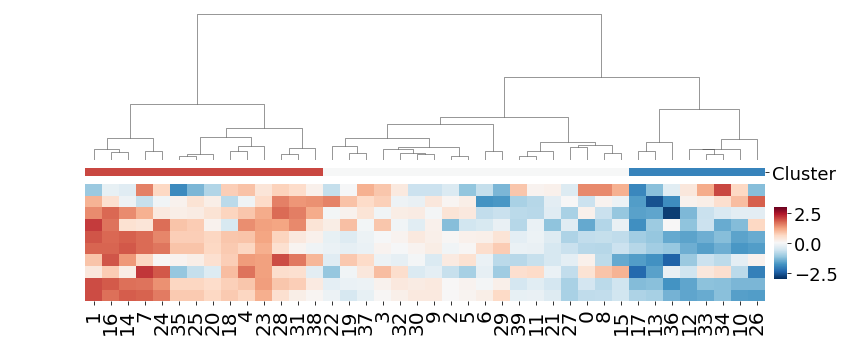

In [14]:
col_linkage = hierarchy.linkage(distance.pdist(est_A, metric='euclidean'), method='ward', optimal_ordering=True)
rank = leaves_list(col_linkage)
cluster = hierarchy.fcluster(col_linkage, t=3, criterion='maxclust')

lut = dict(zip(set(cluster), sns.color_palette("RdBu", n_colors=len(set(cluster))+2)[::2] )) # sns.hls_palette(len(set(cluster)), l=0.5, s=0.8))
col_colors = pd.DataFrame(cluster)[0].map(lut)
cc1 = pd.DataFrame({'Cluster': col_colors.to_numpy()})
col_colors = pd.concat([cc1], axis=1)
fig = plt.figure()
df_nrx = pd.DataFrame(data=est_A.T)
g = sns.clustermap(data=df_nrx, col_linkage=col_linkage, 
                   z_score=0, dendrogram_ratio=(.1, .55), row_cluster=False, 
                   center=0, vmin=-3.0, vmax=3.0, 
                   xticklabels=1, yticklabels=0, 
                   cmap='RdBu_r', col_colors = col_colors,
                   figsize=(12, 5))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 20)
g.fig.subplots_adjust(right=0.9, top=0.957)
g.ax_cbar.set_position((0.91, .2, .015, .2))
# g.fig.suptitle('Title')
# g.fig.tight_layout()
print('order of structures: {}'.format(rank) )
print('cluster of structures: {}'.format(cluster[rank]))
plt.show()

In [15]:
# save the figure
if SAVE_FIG:
    sp = os.path.join(saved_path, 'pred_pf2_linkage_{}.pdf'.format(chrom))
    g.fig.savefig(sp, format='pdf')
    sp = os.path.join(saved_path, 'pred_pf2_linkage_{}.png'.format(chrom))
    g.fig.savefig(sp, format='png')

### Display structures

In [16]:
fig = plt.figure(figsize=(20,18))
print(rank)
color = np.arange(xTAD_3d.shape[1])
cmaps = ['Reds', 'Greys', 'Blues', 'Greens', 'Oranges', 
         'YlOrBr', 'RdPu', 'BuPu', 'GnBu', 'Purples', 
         'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn', 
         'YlOrRd', 'OrRd', 'Greys', 'PuRd']
for i, k in enumerate(rank):
    X = xTAD_3d[k,:,:].squeeze()
    ax = fig.add_subplot(5, 8, i+1, projection='3d')
#     ax.axis('off')
    cmp = plt.get_cmap(cmaps[cluster[k]-1])
    ax.scatter(X[:,0], X[:,1], X[:,2], c=color, cmap=cmp)
    ax.set_box_aspect((np.ptp(X[:,0]), np.ptp(X[:,1]), np.ptp(X[:,2])))
    ax.set_facecolor('xkcd:salmon')
    ax.set_facecolor((0.6, 0.6, 0.6))
    ax.set_title('#{}, Cluster {}'.format(k, cluster[k]-1))
    ax.view_init(elev=10., azim=190)
fig.tight_layout()
fig.show()

[ 1 16 14  7 24 35 25 20 18  4 23 28 31 38 22 19 37  3 32 30  9  2  5  6
 29 39 11 21 27  0  8 15 17 13 36 12 33 34 10 26]


In [17]:
# save the figure
if SAVE_FIG:
    sp = os.path.join(saved_path, 'pred_3D_{}.pdf'.format(chrom))
    fig.savefig(sp, format='pdf')

## Density of distance matrices between clusters

[ 1 16 14  7 24 35 25 20 18  4 23 28 31 38 22 19 37  3 32 30  9  2  5  6
 29 39 11 21 27  0  8 15 17 13 36 12 33 34 10 26]
Ttest_indResult(statistic=33.651026039357724, pvalue=3.989585250467326e-241)
Ttest_indResult(statistic=27.617332125482594, pvalue=8.036527179908683e-166)
Ttest_indResult(statistic=14.976473438056464, pvalue=9.44722601654329e-51)


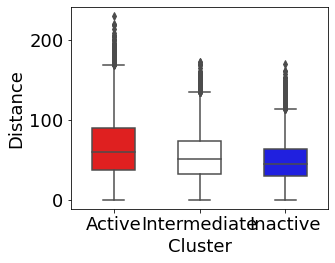

In [18]:
mask = np.mask_indices(nm_fishXi_pdist.shape[0], np.triu, 0)
cluster_number = []
dist = []
print(rank)
for i, k in enumerate(rank):
    m =xTAD_pdist[k, :, :][mask]
    dist = np.append(dist, m)
    cluster_number = np.append(cluster_number, [int(cluster[k])]*len(m) )

d = {'Distance': dist, 'Cluster': cluster_number}
df = pd.DataFrame(data=d)

# sns.set(rc={'figure.figsize':(20, 8)})
fig, axs = plt.subplots(1,1, figsize=(5,4))
pal = {1: "Red", 2: "White", 3: "Blue"}
g = sns.boxplot(x="Cluster", y="Distance", data=df, width=0.5, palette=pal, ax=axs)
axs.set_xticklabels(['Active', 'Intermediate', 'Inactive'])
act = df.loc[df['Cluster'] == 1]['Distance'].values
mid = df.loc[df['Cluster'] == 2]['Distance'].values
inact = df.loc[df['Cluster'] == 3]['Distance'].values
res = ttest_ind(act, inact, alternative="greater")
print(res)
res = ttest_ind(act, mid, alternative="greater")
print(res)
res = ttest_ind(mid, inact, alternative="greater")
print(res)
fig.tight_layout()
fig.show()


In [19]:
# save the figure
if SAVE_FIG:
    sp = os.path.join(saved_path, 'AI_pred_distance_boxplot_{}.pdf'.format(chrom))
    fig.savefig(sp, format='pdf')
    sp = os.path.join(saved_path, 'AI_pred_distance_boxplot_{}.png'.format(chrom))
    fig.savefig(sp, format='png')

## Rotation alignment

In [20]:
def fit_func(x, a, b):
    return a * x + b

In [21]:
fx = np.concatenate((nm_fishXa3d.reshape(1,-1,3), nm_fishXi3d.reshape(1,-1,3)), axis=0)
rx = np.empty((fx.shape[0],xTAD_3d.shape[0]))

mask = np.mask_indices(nm_fishXi_pdist.shape[0], np.triu, 0)
fish_p = (nm_fishXi_pdist[mask] + nm_fishXa_pdist[mask])/2
xTAD_wpdist = np.empty_like(xTAD_pdist)

for k in np.arange(len(xweights)):
    tmp = xTAD_pdist[k,:,:]
    xTAD_wpdist[k,:,:] = xweights[k]*tmp*len(xweights)
xtad_p = np.nanmean(xTAD_wpdist, axis=0)[mask]

popt, pcov = curve_fit(fit_func, xtad_p, fish_p)
print(popt)

for i in np.arange(fx.shape[0]):
    fx3d = fx[i,:,:].squeeze()
    c_fx = fx3d - fx3d.mean(axis=0)
    for j in np.arange(xTAD_3d.shape[0]):
        x = xTAD_3d[j,:,:].squeeze()
        x = x - x.mean(axis=0)
        _, rmsdX = R.align_vectors(c_fx, x*popt[0]) #  
        rx[i,j] = rmsdX

T_F = (rx[0,:]>=rx[1,:]).reshape(1,-1)
T_ind = np.argwhere(T_F).flatten()

[0.01191574 0.89799166]


In [22]:
fx = np.concatenate((fishXa3d, fishXi3d), axis=0) 
rx = np.empty((fx.shape[0],xTAD_3d.shape[0]))

mask = np.mask_indices(nm_fishXi_pdist.shape[0], np.triu, 0)
fish_p = (nm_fishXi_pdist[mask] + nm_fishXa_pdist[mask])/2
xTAD_wpdist = np.empty_like(xTAD_pdist)

for k in np.arange(len(xweights)):
    tmp = xTAD_pdist[k,:,:]
    xTAD_wpdist[k,:,:] = xweights[k]*tmp*len(xweights)
xtad_p = np.nanmean(xTAD_wpdist, axis=0)[mask]

popt, pcov = curve_fit(fit_func, xtad_p, fish_p)
print(popt)

for i in np.arange(fx.shape[0]):
    fx3d = fx[i,:,:].squeeze()
    c_fx = fx3d - fx3d.mean(axis=0)
#     d = np.sqrt( np.mean( np.sum(c_fx**2, axis=1)) )
    for j in np.arange(xTAD_3d.shape[0]):
        x = xTAD_3d[j,:,:].squeeze()
        x = x - x.mean(axis=0)
        _, rmsdX = R.align_vectors(c_fx, x*popt[0]) 
        rx[i,j] = rmsdX

[0.01191574 0.89799166]


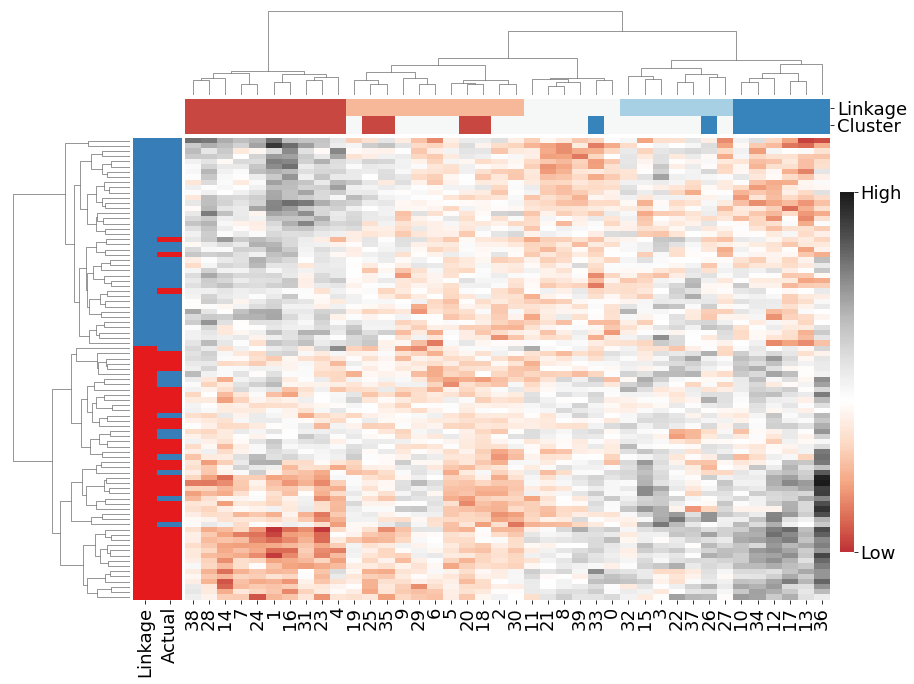

In [23]:
nrx = preprocessing.normalize(rx, norm='l1', axis=1)

col_linkage = hierarchy.linkage(distance.pdist(nrx.T, metric='euclidean'), method='ward', optimal_ordering=True)
col_rank = leaves_list(col_linkage)
col_cluster = hierarchy.fcluster(col_linkage, t=5, criterion='maxclust')

col_lut = dict(zip(set(col_cluster), sns.color_palette("RdBu", n_colors=len(set(col_cluster))) )) # sns.hls_palette(len(set(cluster)), l=0.5, s=0.8))
col_colors1 = pd.DataFrame(col_cluster)[0].map(col_lut)
step = np.ceil(len(set(col_cluster))/len(set(cluster))).astype(int)
col_lut = dict(zip(set(cluster),  sns.color_palette("RdBu", n_colors=len(set(col_cluster)))[::step] )) # sns.hls_palette(len(set(cluster)), l=0.3, s=0.6))
col_colors2 = pd.DataFrame(cluster)[0].map(col_lut)

cc1 = pd.DataFrame({'Linkage': col_colors1.to_numpy()})
cc2 = pd.DataFrame({'Cluster': col_colors2.to_numpy()})
col_colors = pd.concat([cc1, cc2], axis=1)

row_linkage = hierarchy.linkage(distance.pdist(nrx, metric='euclidean'), method='complete', optimal_ordering=True)
row_rank = leaves_list(row_linkage)
row_cluster = 3 - hierarchy.fcluster(row_linkage, t=2, criterion='maxclust')


tick_act = [1 for i in np.arange(len(fishXa3d))]
tick_inact = [2 for i in np.arange(len(fishXi3d))]
yticklabels = np.append(tick_act, tick_inact)

tick_act = ['a#{}'.format(i) for i in np.arange(len(fishXa3d))]
tick_inact = ['i#{}'.format(i) for i in np.arange(len(fishXi3d))]
ytickindex = np.append(tick_act, tick_inact)

row_lut = dict(zip(set(row_cluster), sns.color_palette("Set1", n_colors=len(set(row_cluster))) )) # sns.hls_palette(len(set(cluster)), l=0.5, s=0.8))
row_colors1 = pd.DataFrame(row_cluster)[0].map(row_lut)
rc1 = pd.DataFrame({'Linkage': row_colors1.to_numpy()})
row_lut = dict(zip(set(yticklabels), sns.color_palette("Set1", n_colors=len(set(yticklabels))) )) # sns.hls_palette(len(set(yticklabels)), l=0.3, s=0.6))) 
row_colors2 = pd.DataFrame(yticklabels)[0].map(row_lut)
rc2 = pd.DataFrame({'Actual': row_colors2.to_numpy()})

row_colors = pd.concat([rc1, rc2], axis=1)
df_nrx = pd.DataFrame(data=nrx) #, index=ytickindex)
g = sns.clustermap(data=df_nrx, row_linkage=row_linkage, col_linkage=col_linkage, 
                   z_score=None, dendrogram_ratio=(.15, .15), 
                   center=np.mean(nrx), cbar_kws={"ticks":[nrx.min(), nrx.max()]},
                   row_colors = row_colors, # [row_colors1.to_numpy(), row_colors2.to_numpy()], 
                   col_colors = col_colors, # [col_colors1.to_numpy(), col_colors2.to_numpy()],
                   xticklabels=1, yticklabels=0,
                   cmap='RdGy', figsize=(13, 10))
g.ax_cbar.set_yticklabels(['Low', 'High'])
g.fig.subplots_adjust(right=0.9, top=0.957)
g.ax_cbar.set_position((0.91, .2, .015, .5))
# g.fig.suptitle('Title')
g.fig.tight_layout()

In [24]:
# save the figure
if SAVE_FIG:
    sp = os.path.join(saved_path, 'alignment_AI_rmsd_allsamples_{}.pdf'.format(chrom))
    g.fig.savefig(sp, format='pdf')
    sp = os.path.join(saved_path, 'alignment_AI_rmsd_allsamples_{}.png'.format(chrom))
    g.fig.savefig(sp, format='png')

### Display Xa and Xi

In [25]:
def align_zaxis(X):
    v = X[0, :] - X[-1,:]
    v = v/np.sqrt(v@v.T)
    r = R.from_euler('z', np.arccos(v[1]), degrees=False)
    X = r.apply(X)
    r = R.from_euler('x', np.arccos(v[2]), degrees=False)
    X = r.apply(X)
    return X

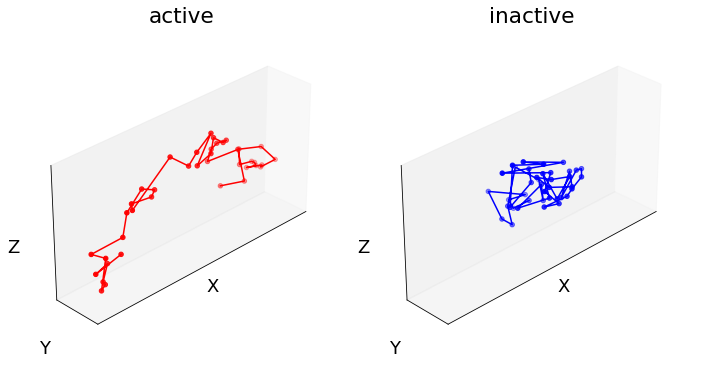

In [26]:
color = np.arange(xTAD_3d.shape[1])
cmaps = ['Reds', 'Blues']

y0 = nm_fishXa3d
y1 = nm_fishXi3d

y0 = y0 - y0.mean(axis=0)
y0 = align_zaxis(y0)

y1 = y1 - y1.mean(axis=0)
y1 = align_zaxis(y1)

fig = plt.figure(figsize=(10, 6))

angle = 45
ax = fig.add_subplot(1, 2, 1, projection='3d')
cmp = plt.get_cmap(cmaps[0])
ax.plot(y0[:,0], y0[:,1], y0[:,2], color='r')
ax.scatter(y0[:,0], y0[:,1], y0[:,2], color='r') # c=color, cmap=cmp)
ax.set_title('active')

A,B,C = y0[:,0], y0[:,1], y0[:,2]
ax.set_box_aspect((np.ptp(A), np.ptp(B), np.ptp(C)))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(A.min()-.1, A.max()+.1)
ax.set_ylim(B.min()-.1, B.max()+.1)
ax.set_zlim(C.min()-.1, C.max()+.1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(30, angle)
# ax.set_facecolor('xkcd:salmon')
# ax.set_facecolor((0.5, 0.5, 0.5))

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title('inactive')
cmp = plt.get_cmap(cmaps[1])

ax.plot3D(y1[:,0], y1[:,1], y1[:,2], color='b')
ax.scatter(y1[:,0], y1[:,1], y1[:,2], color='b') # c=color, cmap=cmp)

ax.set_box_aspect((np.ptp(A), np.ptp(B), np.ptp(C)))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(A.min()-.1, A.max()+.1)
ax.set_ylim(B.min()-.1, B.max()+.1)
ax.set_zlim(C.min()-.1, C.max()+.1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(30, angle)
# ax.set_facecolor('xkcd:salmon')
# ax.set_facecolor((0.5, 0.5, 0.5))
fig.tight_layout()
fig.show()

In [27]:
# save the figure
if SAVE_FIG:
    sp = os.path.join(saved_path, 'True_mean_3D_{}.pdf'.format(chrom))
    fig.savefig(sp, format='pdf', bbox_inches='tight')
    sp = os.path.join(saved_path, 'True_mean_3D_{}.png'.format(chrom))
    fig.savefig(sp, format='png', bbox_inches='tight')

### Display structure

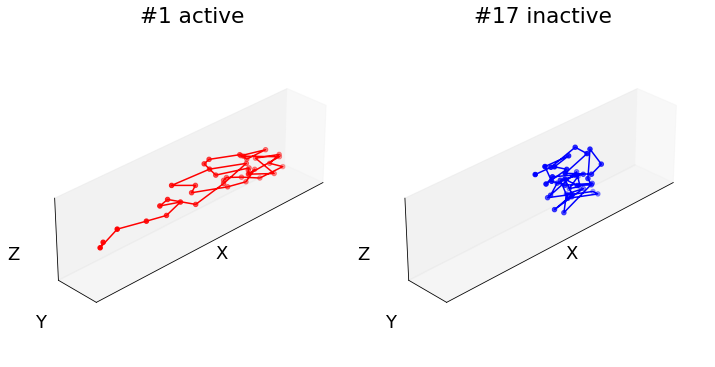

In [28]:
fig = plt.figure(figsize=(10, 6))
# color = np.arange(xTAD_3d.shape[0])
cmaps = ['Reds', 'Blues']

k0 = rank[0]
X0 = xTAD_3d[k0,:,:].squeeze()
X0 = X0 - X0.mean(axis=0)
X0 = align_zaxis(X0)

k1 = 17 # rank[-1]
X1 = xTAD_3d[k1,:,:].squeeze()
X1 = X1 - X1.mean(axis=0)
X1 = align_zaxis(X1)
    
axs = fig.add_subplot(1, 2, 1, projection='3d')
cmp = plt.get_cmap(cmaps[0])
r = R.from_euler('y', 90, degrees=True)
X0 = r.apply(X0)
A,B,C = X0[:,0], X0[:,1], X0[:,2]

axs.plot3D(X0[:,0], X0[:,1], X0[:,2], color='r')
axs.scatter(X0[:,0], X0[:,1], X0[:,2], color='r') #  c=color, cmap=cmp
axs.set_box_aspect((np.ptp(A), np.ptp(B), np.ptp(C)))
axs.set_xlabel('X')
axs.set_ylabel('Y')
axs.set_zlabel('Z')
axs.set_title('#{} active'.format(k0))
axs.set_xlim(A.min()-20, A.max()+20)
axs.set_ylim(B.min()-20, B.max()+20)
axs.set_zlim(C.min()-20, C.max()+20)
axs.set_xticks([])
axs.set_yticks([])
axs.set_zticks([])
angle = 45
axs.view_init(30, angle)
# axs.set_facecolor('xkcd:salmon')
# axs.set_facecolor((0.5, 0.5, 0.5))

axs = fig.add_subplot(1, 2, 2, projection='3d')
cmp = plt.get_cmap(cmaps[1])
axs.plot3D(X1[:,0], X1[:,1], X1[:,2], color='b')
axs.scatter(X1[:,0], X1[:,1], X1[:,2], color='b', cmap='Reds') # c=color, cmap=cmp
axs.set_box_aspect((np.ptp(A), np.ptp(B), np.ptp(C)))
axs.set_xlabel('X')
axs.set_ylabel('Y')
axs.set_zlabel('Z')
axs.set_title('#{} inactive'.format(k1))
axs.set_xlim(A.min()-20, A.max()+20)
axs.set_ylim(B.min()-20, B.max()+20)
axs.set_zlim(C.min()-20, C.max()+20)
axs.set_xticks([])
axs.set_yticks([])
axs.set_zticks([])
angle = 45
axs.view_init(30, angle)    
# axs.set_facecolor('xkcd:salmon')
# axs.set_facecolor((0.5, 0.5, 0.5))

fig.tight_layout()
fig.show()

In [29]:
# save the figure
if SAVE_FIG:
    sp = os.path.join(saved_path, 'pred_{}-{}_3D_{}.pdf'.format(k0, k1, chrom))
    fig.savefig(sp, format='pdf',bbox_inches='tight')
    sp = os.path.join(saved_path, 'pred_{}-{}_3D_{}.png'.format(k0, k1, chrom))
    fig.savefig(sp, format='png',bbox_inches='tight')